In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import poisson,skellam
from scipy.optimize import minimize

In [2]:
df0 = pd.read_excel("https://github.com/futpythontrader/YouTube/blob/main/x_FutPythonTrader_Base_de_Dados_Temporada_Atual_x.xlsx?raw=true")
df = df0[['League','Home','Away','FT_Goals_H','FT_Goals_A']]
df = df[df.League == "Brazil Serie A"]
# Ajustando o Índice
df.reset_index(inplace=True, drop=True)
df.index = df.index.set_names(['Nº'])
df = df.rename(index=lambda x: x + 1)
df.head()

,League,Home,Away,FT_Goals_H,FT_Goals_A
Nº,,,,,
1,Brazil Serie A,Fluminense,Santos,0,0
2,Brazil Serie A,Atlético GO,Flamengo,1,1
3,Brazil Serie A,Palmeiras,Ceará,2,3
4,Brazil Serie A,Coritiba,Goiás,3,0
5,Brazil Serie A,Atlético Mineiro,Internacional,2,0


In [3]:
df = df[:-10]
df.mean()

FT_Goals_H    1.372
FT_Goals_A    0.936
dtype: float64

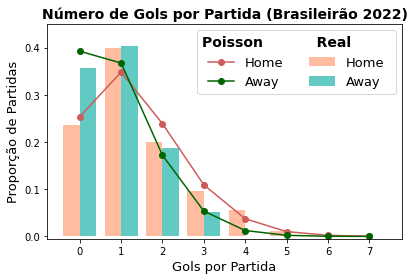

In [4]:
# Construção do Modelo de Poisson para cada valor de média de Gols
poisson_pred = np.column_stack([[poisson.pmf(i, df.mean()[j]) for i in range(8)] for j in range(2)])

# Plotando o Histograma dos Gols
plt.hist(df[['FT_Goals_H', 'FT_Goals_A']].values, range(9), 
         alpha=0.7, label=['Home', 'Away'],density=True, stacked=False, color=["#FFA07A", "#20B2AA"])

# Adicionando as Linhas da Distribuição de Poisson
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Real        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(8)])
plt.xlabel("Gols por Partida",size=13)
plt.ylabel("Proporção de Partidas",size=13)
plt.title("Número de Gols por Partida (Brasileirão 2022)",size=14,fontweight='bold')
plt.ylim([-0.005, 0.45])
plt.tight_layout()
plt.show()

In [5]:
df_halves = df0
df_halves = df_halves[['FT_Goals_H', 'FT_Goals_A', 'HT_Goals_H', 'HT_Goals_A']]
df_halves['FHgoals'] = df_halves['HT_Goals_H'] + df_halves['HT_Goals_A']
df_halves['SHgoals'] = df_halves['FT_Goals_H'] + df_halves['FT_Goals_A'] - df_halves['FHgoals']
df_halves = df_halves[['FHgoals', 'SHgoals']]
df_halves.mean()

FHgoals    1.198900
SHgoals    1.481638
dtype: float64

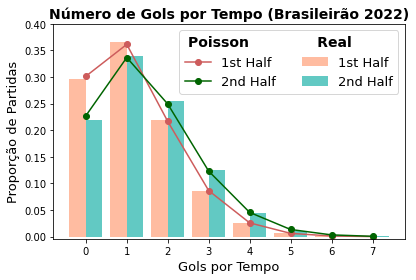

In [6]:
poisson_halves_pred = np.column_stack([[poisson.pmf(i, df_halves.mean()[j]) for i in range(8)] for j in range(2)])

plt.hist(df_halves.values, range(9), 
         alpha=0.7, label=['1st Half', '2nd Half'],density=True, stacked=False, color=["#FFA07A", "#20B2AA"])

pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_halves_pred[:,0],
                  linestyle='-', marker='o',label="1st Half", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_halves_pred[:,1],
                  linestyle='-', marker='o',label="2nd Half", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson              Real        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(8)])
plt.xlabel("Gols por Tempo",size=13)
plt.ylabel("Proporção de Partidas",size=13)
plt.title("Número de Gols por Tempo (Brasileirão 2022)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

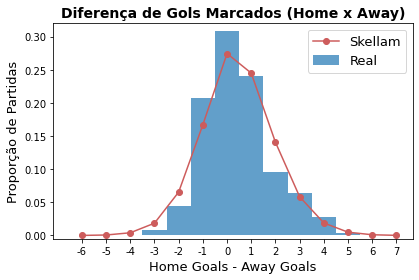

In [7]:
skellam_pred = [skellam.pmf(i,  df.mean()[0],  df.mean()[1]) for i in range(-6,8)]

plt.hist(df[['FT_Goals_H']].values - df[['FT_Goals_A']].values, range(-6,8), 
         alpha=0.7, label='Real',density=True, stacked=False)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proporção de Partidas",size=13)
plt.title("Diferença de Gols Marcados (Home x Away)",size=14,fontweight='bold')
plt.ylim([-0.005, 0.32])
plt.tight_layout()
plt.show()

In [8]:
home = input("Digite o nome do time Mandante: ")
away = input("Digite o nome do time Visitante: ")

Digite o nome do time Mandante: Ceará
Digite o nome do time Visitante: São Paulo


In [9]:
goal_model_data = pd.concat([df[['Home','Away','FT_Goals_H']].assign(home=1).rename(columns={'Home':'team', 'Away':'opponent','FT_Goals_A':'goals'}),
           df[['Away','Home','FT_Goals_A']].assign(home=0).rename(columns={'Away':'team', 'Home':'opponent','FT_Goals_A':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()


def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [10]:
game = simulate_match(poisson_model, home, away, max_goals=10)
print(game[0:5, 0:5])

[[0.09485191 0.09908791 0.05175654 0.01802265 0.00470688]
 [0.12432992 0.12988239 0.06784141 0.02362371 0.00616968]
 [0.08148455 0.08512358 0.04446256 0.01548274 0.00404355]
 [0.03560276 0.03719274 0.01942687 0.00676482 0.00176673]
 [0.01166684 0.01218787 0.00636608 0.0022168  0.00057895]]


In [11]:
from matplotlib.colors import ListedColormap

def matrix_gif(matrix, colour_matrix, colour_map, subtitle="", heatmap=False, alpha=0.8):
    fig, ax1 = plt.subplots(1, figsize=(5,5))
    if heatmap:
        ax1.matshow(matrix, alpha=alpha)
    else:
        ax1.matshow(colour_matrix, cmap=colour_map, alpha=alpha)
    ax1.tick_params(axis=u'both', which=u'both',length=0)
    ax1.grid(which='major', axis='both', linestyle='')
    ax1.set_xlabel(away, fontsize=12)
    ax1.set_ylabel(home, fontsize=12)
    ax1.xaxis.set_label_position('top')
    nrows, ncols = matrix.shape
    for i in range(nrows):
        for j in range(ncols):
            c = matrix[i][j]
            ax1.text(j, i, str(round(c,4)), va='center', ha='center', size=13)
    plt.figtext(0.5, 0.05, subtitle, horizontalalignment='center',
                fontsize=14, multialignment='left', fontweight='bold')
    return fig

cmap = ListedColormap(['w', '#04f5ff', '#00ff85', '#e90052'])
matrix = simulate_match(poisson_model, home, away, max_goals=5)
matn = len(matrix)
matrix_gif(matrix, matrix, ListedColormap(['w']), heatmap=True, 
           alpha=0.6, subtitle="Match Score Probability Matrix").savefig("match_matrix_0.png")
plt.close()
for t,(mat,colour,subtitle) in enumerate(zip([np.zeros((matn, matn)), np.tril(np.ones((matn,matn)),-1),
                            np.triu(np.ones((matn,matn))*2,1), np.diag([3]*matn),
                                             np.array([0 if i+j<3 else 1 for i in range(matn) for j in range(matn)]).reshape(matn,matn)],
                          ['w', '#04f5ff', '#00ff85', '#e90052','#EAF205'],
                                   ['Match Score Probability Matrix', 'Home Win', 'Away Win', 'Draw', 'Over 2.5 goals'])):
    matrix_gif(matrix, mat, ListedColormap(['w'] + [colour]), heatmap=False, 
               alpha=0.6, subtitle=subtitle).savefig("match_matrix_{}.png".format(t+1))
    plt.close()